# Final ML Project
## Daniel Bernal, Raymond Vuong, Rohit Punjani, and Neal Davar 


In [980]:
# import statements

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from scipy.stats import chi2_contingency
from sklearn.feature_selection import f_regression


In [981]:
# Constants and other global variables: 

IL_F_ITERATIONS = 50

In [982]:
# clean data by dropping cols like Id, imputing value
# depending on the feature, and dropping duplicates:
def clean_data(dataset): 
    dataset.drop('Id', axis=1, inplace=True)
    null_counts = dataset.isnull().sum()
    missing_features = null_counts[null_counts > 0]
    print(missing_features)    
    
   
    # fillna on the basis of whether MasVnrArea, LotFrontage, or any other categorical feature with na values
    dataset['MSZoning'].fillna('None', inplace=True)
    dataset['LotFrontage'].fillna(0, inplace=True)
    dataset['Alley'].fillna('None', inplace=True)
    dataset['Utilities'].fillna('None', inplace=True)
    dataset['Exterior1st'].fillna('None', inplace=True)
    dataset['Exterior2nd'].fillna('None', inplace=True)
    dataset['MasVnrType'].fillna('None', inplace=True)
    dataset['MasVnrArea'].fillna(0, inplace=True)
    dataset['BsmtQual'].fillna('None', inplace=True)
    dataset['BsmtCond'].fillna('None', inplace=True)
    dataset['BsmtExposure'].fillna('None', inplace=True)
    dataset['BsmtFinType1'].fillna('None', inplace=True)
    dataset['BsmtFinSF1'].fillna(0, inplace=True)
    dataset['BsmtFinType2'].fillna('None', inplace=True)
    dataset['BsmtFinSF2'].fillna(0, inplace=True)
    dataset['BsmtUnfSF'].fillna(0, inplace=True)
    dataset['TotalBsmtSF'].fillna(0, inplace=True)
    dataset['BsmtFullBath'].fillna(0, inplace=True)
    dataset['BsmtHalfBath'].fillna(0, inplace=True)
    dataset['KitchenQual'].fillna('None', inplace=True)
    dataset['Functional'].fillna('None', inplace=True)
    dataset['FireplaceQu'].fillna('None', inplace=True)
    dataset['GarageType'].fillna('None', inplace=True)
    dataset['GarageYrBlt'].fillna(dataset['GarageYrBlt'].mean(), inplace=True)
    dataset['GarageFinish'].fillna('None', inplace=True)
    dataset['GarageCars'].fillna(0, inplace=True)
    dataset['GarageArea'].fillna(0, inplace=True)
    dataset['GarageQual'].fillna('None', inplace=True)
    dataset['GarageCond'].fillna('None', inplace=True)
    dataset['PoolQC'].fillna('None', inplace=True)
    dataset['Fence'].fillna('None', inplace=True)
    dataset['MiscFeature'].fillna('None', inplace=True)
    dataset['SaleType'].fillna('None', inplace=True)

    # drop duplicates:
    dataset.drop_duplicates(keep=False, inplace=True)

    # Changing categorial features to be stored as string
    dataset['MSSubClass'] = dataset['MSSubClass'].astype(str)


    return dataset

In [983]:
# on hot encode the data
def one_hot_encode(dataset):
    ohe_col_list = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
                    'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']   

    dataset_dropped = pd.get_dummies(data=dataset, columns=ohe_col_list, drop_first=True)

    return dataset_dropped

In [984]:
# perform one square chi test: 
def one_square_chi(dataset): 
    contingency_table = pd.crosstab(
        dataset['HouseStyle'], dataset['Neighborhood'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print('Chi-squared statistic:', chi2)
    print('P-value:', p)
    print('Degrees of freedom:', dof)
    print('Expected values:', expected)


In [985]:
# perform correlation of every feature against the "SalePrice" label: 
def corr_salePrice(dataset): 
    # X = training features, y = target class
    # Also did we make sure to seperate the target class before training on it??
    X, y = dataset, dataset['SalePrice']

    # compute the F-value and p-value for each feature
    f_values, p_values = f_regression(X, y)

    # print the F-value and p-value for each feature
    # High F-value and low p-value = high significance b/w feature and 'sales price'
    for i, (f_val, p_val) in enumerate(zip(f_values, p_values)):
        print('Feature %d: F-value=%.2f, p-value=%.4f' % (i, f_val, p_val))


In [986]:
def explore_data(dataset):
    # grab all the numeric features and plot histograms
    numeric_feats = dataset.select_dtypes(
    include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64'])
    for i in numeric_feats.columns:
        plt.hist(numeric_feats[i])
        plt.title(i)
        plt.show()

    # plot correlation between features: 
    corr_mat = numeric_feats.corr()
    plt.subplots(figsize=(12, 9))
    sns.heatmap(corr_mat, square=True)
    plt.show()

In [987]:
# Uses the isolation forest technique to find outliers across 50 iterations
# and removes records that are recorded as outliers > 10% of the time
def run_isolation_forest(training):
    # use isolation forests to find potential outliers:
    freq_outlier_map = {} 
    for i in range(0, IL_F_ITERATIONS):
        anomalies = IsolationForest().fit_predict(training, 0.5)
        training['anomalies'] = anomalies
        outlier_indices = training.loc[training['anomalies'] == -1].index
        # add outlier freqs to map
        for j in range(0, len(outlier_indices)):
            count = 0
            if outlier_indices[j] in freq_outlier_map: 
                count = freq_outlier_map[outlier_indices[j]]
            freq_outlier_map[outlier_indices[j]] = count + 1
        

        
    # drop outliers that are detected as anomalies more than 10% of the time
    final_outlier_indices = []
    print('Total # of Outliers: ')
    for outlier_index in freq_outlier_map.keys(): 
        if freq_outlier_map[outlier_index] > (0.10 * IL_F_ITERATIONS):
            final_outlier_indices.append(outlier_index)
    print(len(final_outlier_indices))
    print('Number of data points before outlier removal: ')
    print(len(training))
    training.drop(index=final_outlier_indices, inplace=True)
    print('Number of data points before after outlier removal: ')
    print(len(training))
    training.drop('anomalies', axis=1, inplace=True)


In [988]:
# function that normalizes the training and testing data:
def normalize_data(train, test):
    # your code goes here
    train_norm = (train - train.min()) / (train.max() - train.min())
    test_norm = (test - test.min()) / (test.max() - test.min())
    return train_norm, test_norm

In [989]:
# feature engineering of consolidating bathroom
def fe_bathrooms(dataset):
    # consolidate bathroom columns into one col:
    dataset['TotalBathrooms'] = \
        dataset['FullBath'] + (0.5 * dataset['HalfBath']) + \
        dataset['BsmtFullBath'] + (0.5 * dataset['BsmtHalfBath'])
    res = dataset.drop(['FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath'], axis=1, inplace=False)
    return res

In [990]:
# feature engineering of consolidating porch sq ft: 
def fe_porch(dataset):
    # consolidate porch area into one column
    dataset['TotalPorchSF'] = dataset['OpenPorchSF'] + \
        dataset['EnclosedPorch'] + \
        dataset['3SsnPorch'] + dataset['ScreenPorch']

    res = dataset.drop(['OpenPorchSF', 'EnclosedPorch',
                  '3SsnPorch', 'ScreenPorch'], axis=1, inplace=False)

    return res

In [991]:
# for multicollinar features, remove one of the two multicollinear features
def multi_collinear_removal(dataset): 
    # from the heat map GarageCars and GarageArea were multicollinear -> drop GarageArea
    # likewise 1stFlrSF and 2ndFlrSF were collinear -> drop 2ndFlrSF 
    res = dataset.drop(['GarageArea', '2ndFlrSF'], axis=1, inplace=False)
    return res


In [992]:
# Run Decision Tree Regression on our Data:
def do_decision_tree_regression(training, testing):
    print('shape of training: ', training.shape)
    print('shape of testing: ', testing.shape)
    labels = training['SalePrice']
    features = training.drop('SalePrice', axis=1, inplace=False)
    testing_labels = testing['SalePrice']
    testing_features = testing.drop('SalePrice', axis=1, inplace=False)
    pca = PCA()
    dtr = DecisionTreeRegressor()
    pipeline = Pipeline(
        steps=[('pca', pca), ('dt', dtr)])
    param_grid = {'pca__n_components': list(range(10,13)),
                  'dt__max_depth': [17,18,19,20], 'dt__min_samples_leaf': [
        10,11,12,13], 'dt__max_features': [8,9,10]}

    grid = GridSearchCV(pipeline, param_grid, scoring='r2', cv=5)
    grid.fit(features, labels)
    print("DECISION TREE REGRESSION MODEL: ")
    print("Best number of dimensions: ",
          grid.best_params_['pca__n_components'])
    print("Best parameters: ", grid.best_params_)
    # nested cross val
    cv = cross_val_score(grid, features, labels, cv=5)
    r2 = sum(cv)/cv.size
    print("R2 with cross val: ", r2)
    test_accuracy = grid.score(testing_features, testing_labels)
    print("Accuracy after running model on test set: ", test_accuracy)


In [993]:
# run adaboost regression on training data
def do_adaBoost(training, testing):
    print('shape of training: ', training.shape)
    print('shape of testing: ', testing.shape)
    labels = training['SalePrice']
    features = training.drop('SalePrice', axis=1, inplace=False)
    testing_labels = testing['SalePrice']
    testing_features = testing.drop('SalePrice', axis=1, inplace=False)
    pca = PCA()
    ada = AdaBoostRegressor()
    pipeline = Pipeline(steps=[('pca', pca), ('ada', ada)])
    param_grid = {'pca__n_components': list(range(8,14)), 'ada__n_estimators': [10,11,12,13]}

    grid = GridSearchCV(pipeline, param_grid, scoring='r2', cv=5)
    grid.fit(features, labels)
    print("ADA BOOST MODEL: ")
    print("Best number of dimensions: ",
          grid.best_params_['pca__n_components'])
    print("Best parameters: ", grid.best_params_)
    # nested cross val
    cv = cross_val_score(grid, features, labels, cv=5)
    r2 = sum(cv)/cv.size
    print("R2 with cross val: ", r2)
    test_accuracy = grid.score(testing_features, testing_labels)
    print("Accuracy after running model on test set: ", test_accuracy)


In [994]:
# KNN Regression Model Implementation:
#KNN regression
def do_KNN_regression(training, testing):
    print('shape of training: ', training.shape)
    print('shape of testing: ', testing.shape)
    labels = training['SalePrice']
    features = training.drop('SalePrice', axis=1, inplace=False)
    testing_labels = testing['SalePrice']
    testing_features = testing.drop('SalePrice', axis=1, inplace=False)
    pca = PCA()
    knn = KNeighborsRegressor()
    pipeline = Pipeline(steps=[('pca', pca), ('knn', knn)])
    param_grid = {'pca__n_components': list(range(9,14)), 'knn__n_neighbors': [
        10,20,30,40]}

    grid = GridSearchCV(pipeline, param_grid, scoring='r2', cv=5)
    grid.fit(features, labels)
    print("KNN REGRESSION MODEL: ")
    print("Best number of dimensions: ",
          grid.best_params_['pca__n_components'])
    print("Best parameters: ", grid.best_params_)
    # nested cross val
    cv = cross_val_score(grid, features, labels, cv=5)
    r2 = sum(cv)/cv.size
    print("R2 with cross val: ", r2)
    test_accuracy = grid.score(testing_features, testing_labels)
    print("Accuracy after running model on test set: ", test_accuracy)



In [995]:
# run random forest algorithm on dataset: 
def do_random_forest_regression(training, testing):
  labels = training['SalePrice']
  features = training.drop('SalePrice', axis=1, inplace=False)
  testing_labels = testing['SalePrice']
  testing_features = testing.drop('SalePrice', axis=1, inplace=False)
  dt = RandomForestRegressor()
  pca = PCA()
  pipeline = Pipeline(steps=[('pca', pca), ('dt', dt)])
  #innerloop of crossval
  param_grid = {'pca__n_components': list(range(12, 17)), 
                'dt__max_depth': [1,3,5,7,9], 'dt__min_samples_leaf': [
      5, 10, 15, 20, 30, 40], 'dt__max_features': [1,3,5,10]}
  grid = GridSearchCV(pipeline,
                      param_grid, cv=5, scoring='r2')
  grid.fit(features, labels)
  print("RANDOM FOREST REGRESSION MODEL: ")
  print("Best parameters: ", grid.best_params_)
  cv = cross_val_score(grid, features, labels, cv=5)
  r2 = sum(cv)/cv.size
  # TODO: Uncomment this: 
  #   Scores[0,0] = r2
  print("R2 with cross val: ", r2)
  test_accuracy = grid.score(testing_features, testing_labels)
  print("Accuracy after running model on test set: ", test_accuracy)


In [996]:
# run gradient boosting regression on dataset
def do_gradient_boosting_regression(training, testing):
  labels = training['SalePrice']
  features = training.drop('SalePrice', axis = 1, inplace=False)
  testing_labels = testing['SalePrice']
  testing_features = testing.drop('SalePrice', axis = 1, inplace=False)
  gbr = GradientBoostingRegressor()
  pca = PCA()
  pipeline = Pipeline(steps=[('pca', pca), ('gbr', gbr)])

  #innerloop of crossval
  param_grid = {'pca__n_components': list(range(10,15)), 'gbr__max_depth': [2,4,6,8], 'gbr__min_samples_leaf': [2,3,5,7], 'gbr__max_features': [3,5,7,9]}
  grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2')
  grid.fit(features, labels)
  print("GRADIENT BOOSTING MODEL: ")
  print("Best parameters: ", grid.best_params_)
  cv = cross_val_score(grid, features, labels, cv = 5)
  r2 = sum(cv)/cv.size
# TODO: Uncomment this:
#   Scores[0,2] = r2
  print("R2 with cross val", r2)
  test_accuracy = grid.score(testing_features, testing_labels)
  print("Accuracy after running model on test set: ", test_accuracy)


In [997]:
# run a linear regression model
def do_LinReg(training, testing):
    print('shape of training: ', training.shape)
    print('shape of testing: ', testing.shape)
    labels = training['SalePrice']
    labels.values.ravel()
    features = training.drop('SalePrice', axis=1, inplace=False)
    testing_labels = testing['SalePrice']
    testing_features = testing.drop('SalePrice', axis=1, inplace=False)
    print(features.shape)
    print(labels.shape)
    print(features.head())
    print(labels.head())
    param_grid = {
        'pca__n_components': [9,13,15,20,24]
    }
    pca = PCA()
    linReg = LinearRegression() 
    pipeline = Pipeline(steps=[('pca', pca), ('linreg', linReg)])
    grid = GridSearchCV(pipeline, param_grid, cv=5)
    grid.fit(features, labels)
    print("LINEAR REGRESSION MODEL: ")
    print("Best parameters: ", grid.best_params_)
    # nested cross val
    cv = cross_val_score(grid, features, labels, cv=5)
    r2 = sum(cv)/cv.size
    print("R2 with cross val: ", r2)
    test_accuracy = grid.score(testing_features, testing_labels)
    print("Accuracy after running model on test set: ", test_accuracy)


LotFrontage     123
Alley           683
MasVnrType        5
MasVnrArea        5
BsmtQual         19
BsmtCond         19
BsmtExposure     20
BsmtFinType1     19
BsmtFinType2     20
FireplaceQu     329
GarageType       31
GarageYrBlt      31
GarageFinish     31
GarageQual       31
GarageCond       31
PoolQC          725
Fence           584
MiscFeature     702
dtype: int64
LotFrontage     136
Alley           686
MasVnrType        3
MasVnrArea        3
BsmtQual         18
BsmtCond         18
BsmtExposure     18
BsmtFinType1     18
BsmtFinType2     18
Electrical        1
FireplaceQu     361
GarageType       50
GarageYrBlt      50
GarageFinish     50
GarageQual       50
GarageCond       50
PoolQC          728
Fence           595
MiscFeature     704
dtype: int64


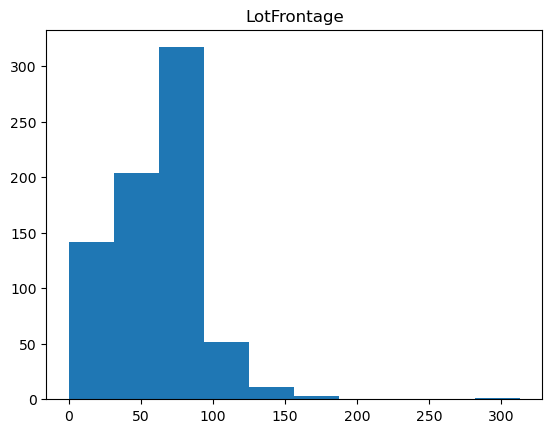

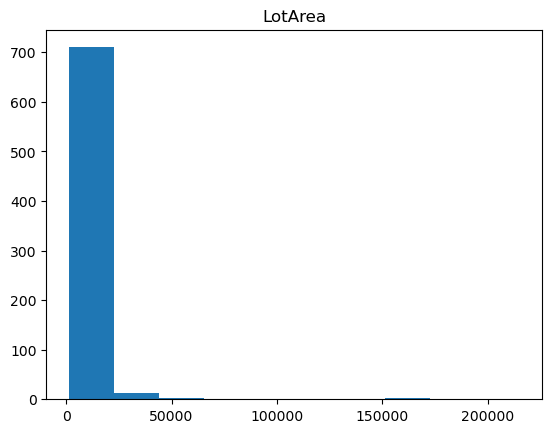

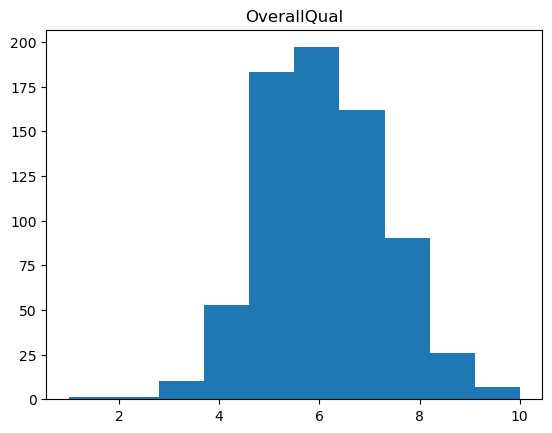

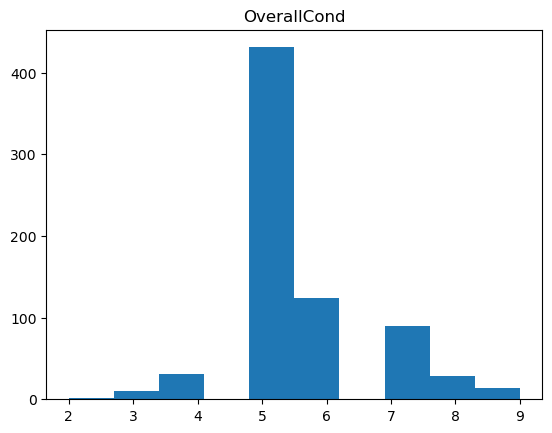

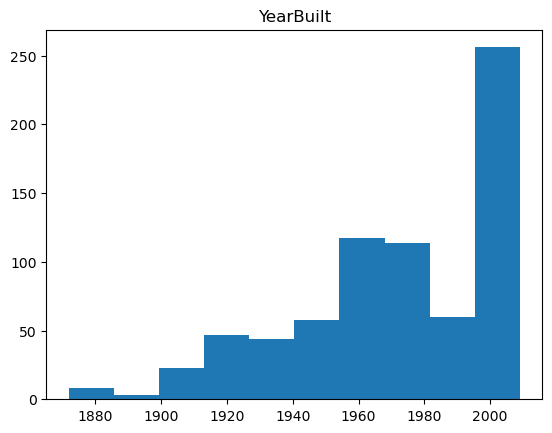

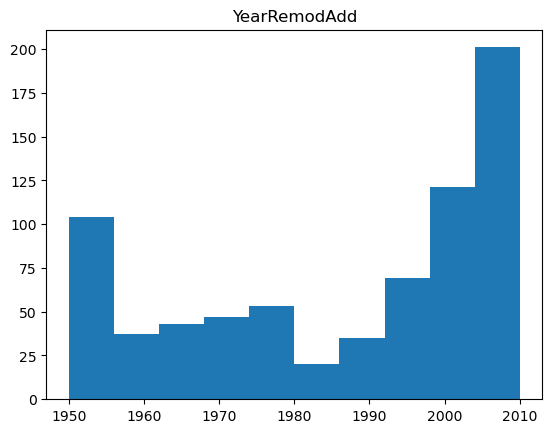

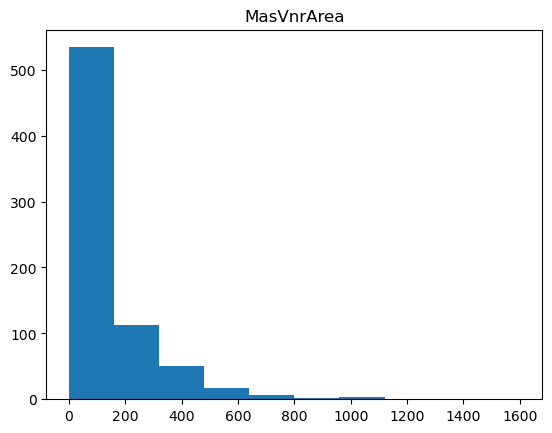

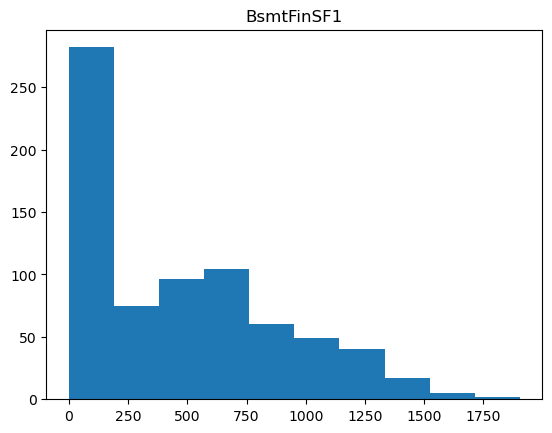

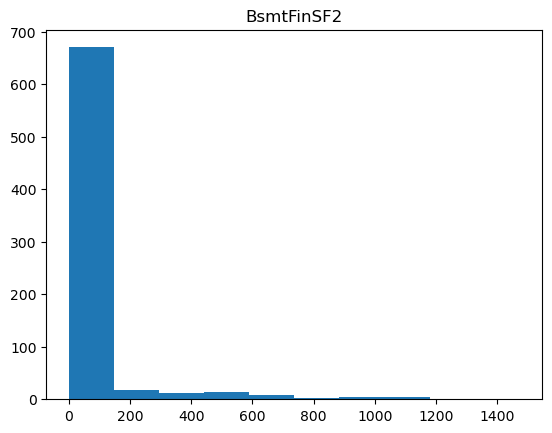

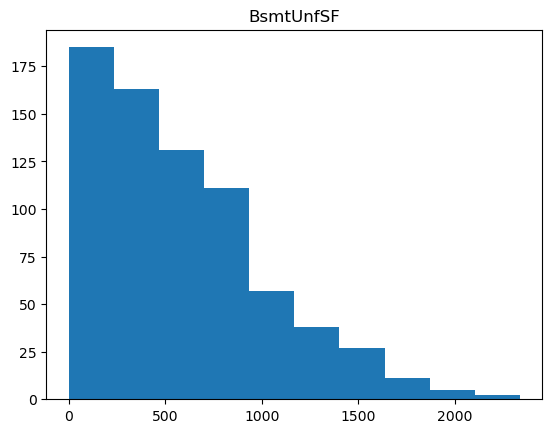

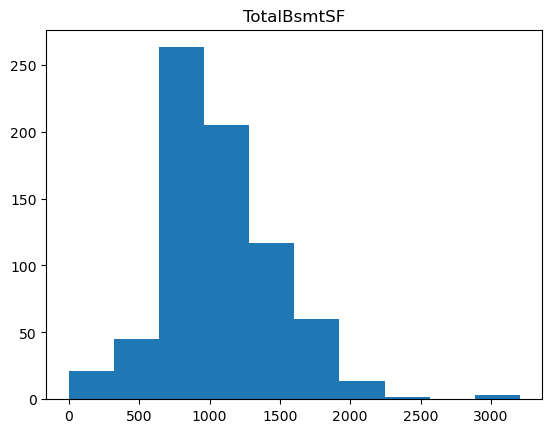

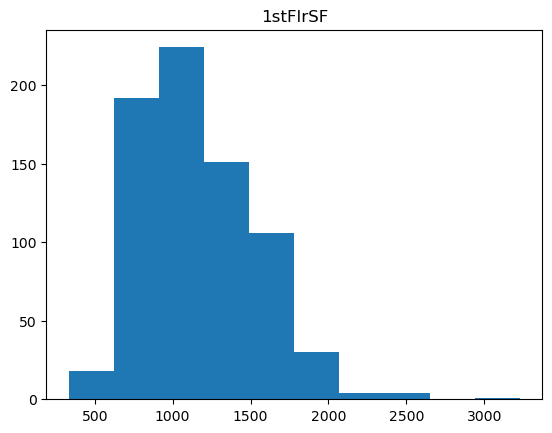

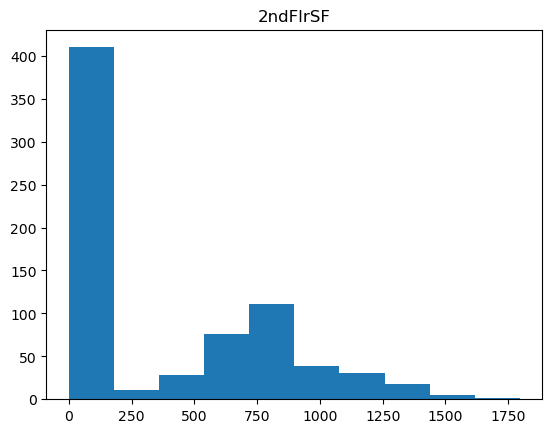

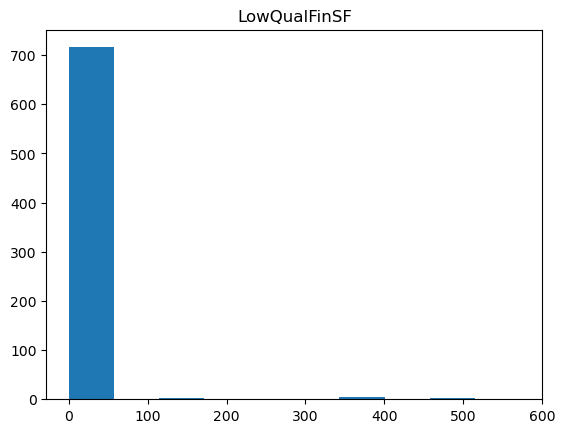

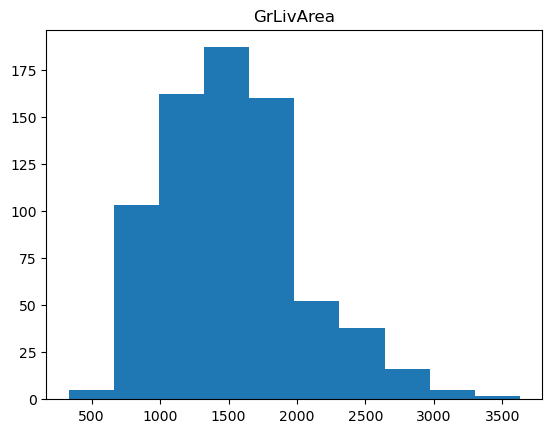

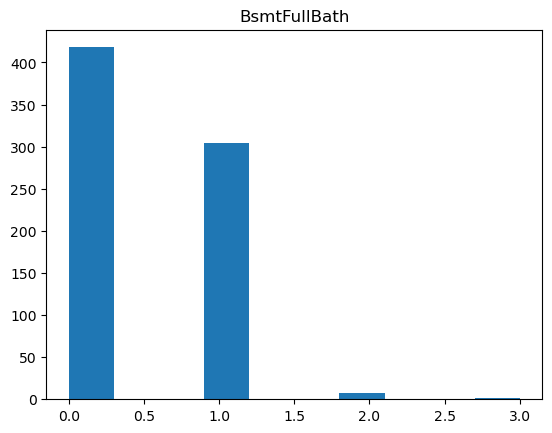

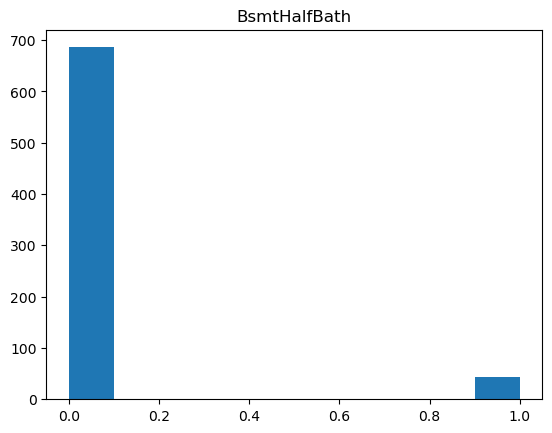

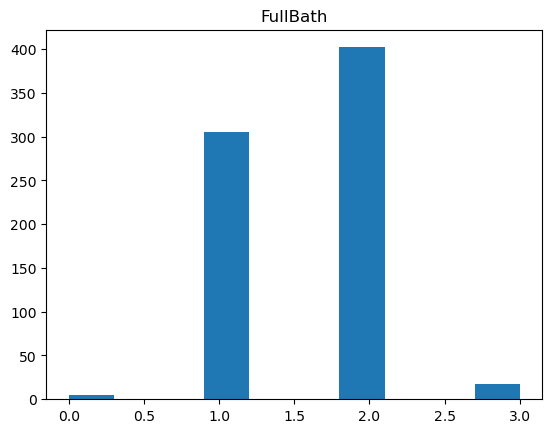

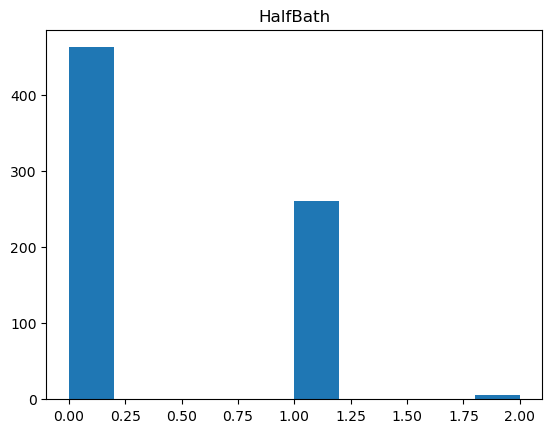

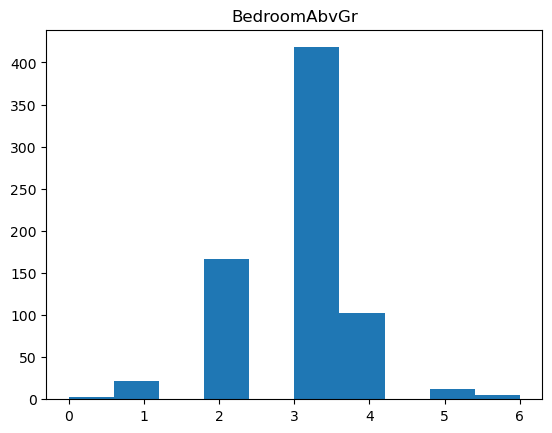

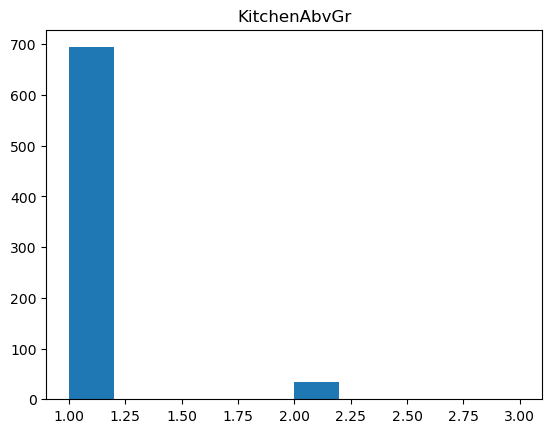

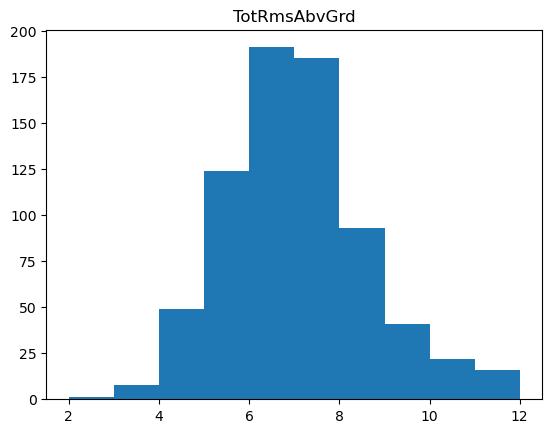

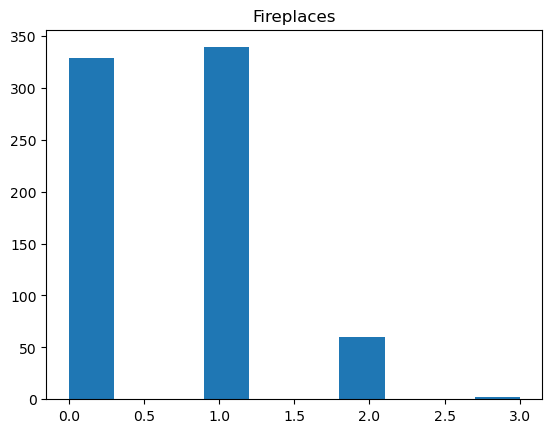

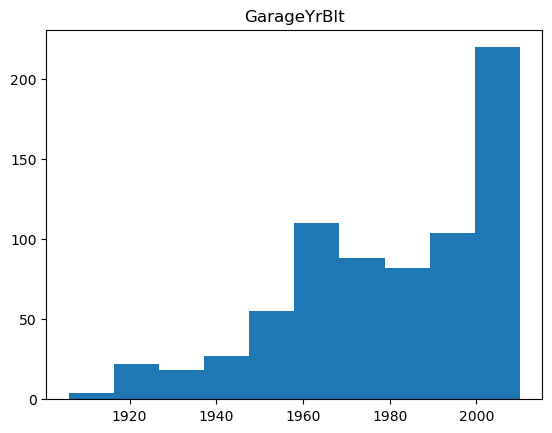

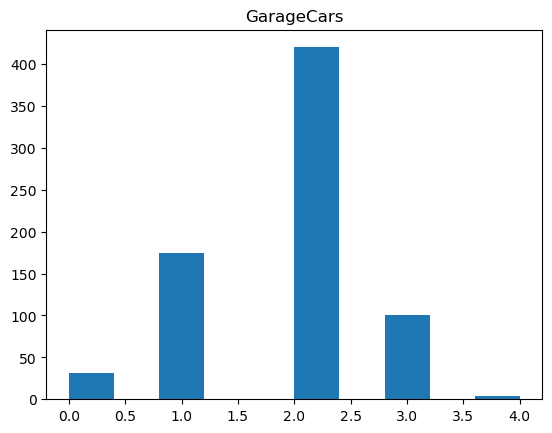

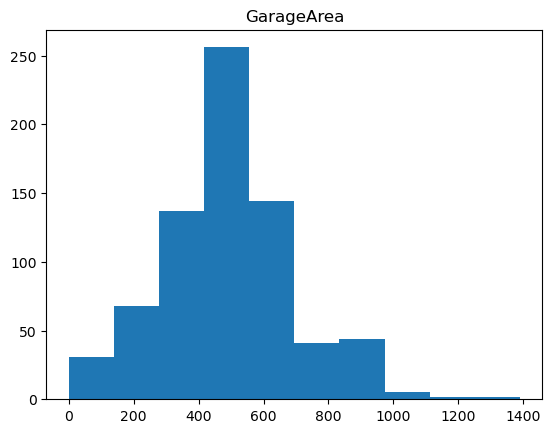

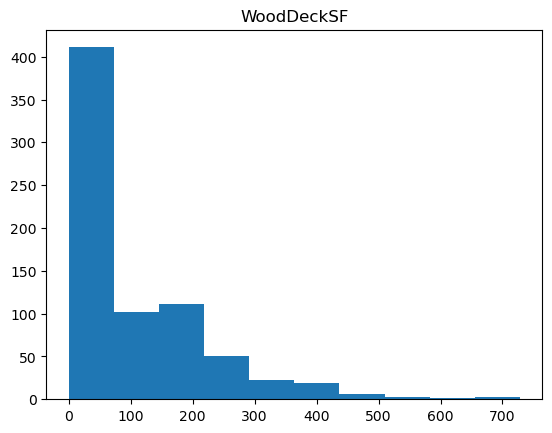

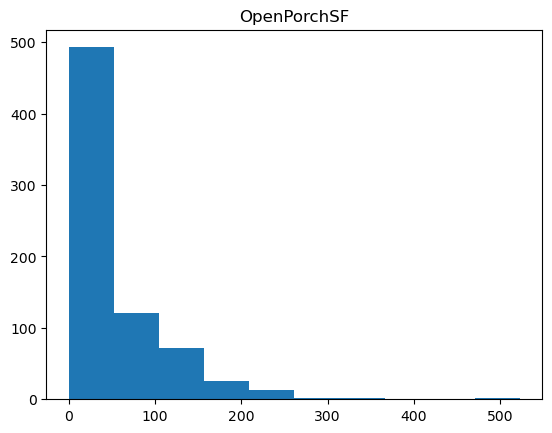

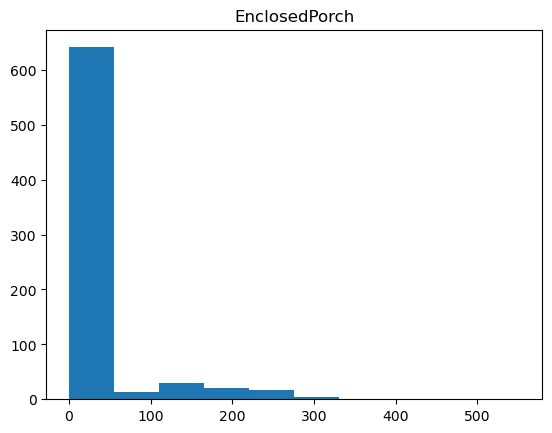

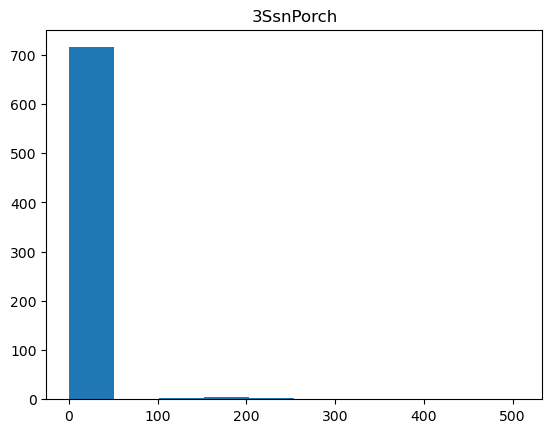

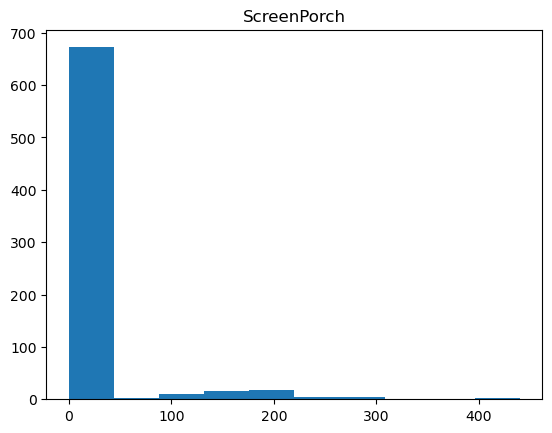

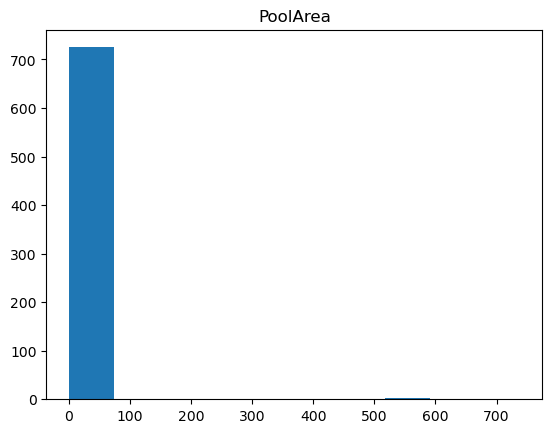

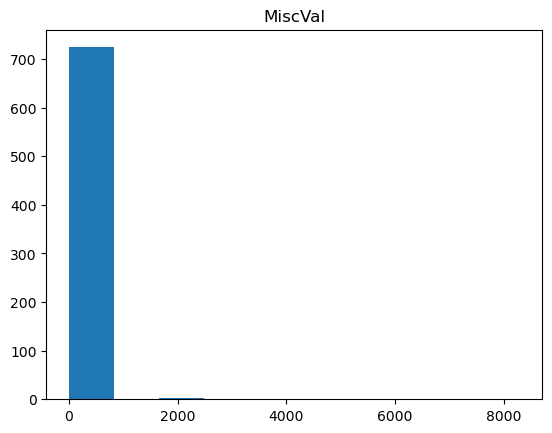

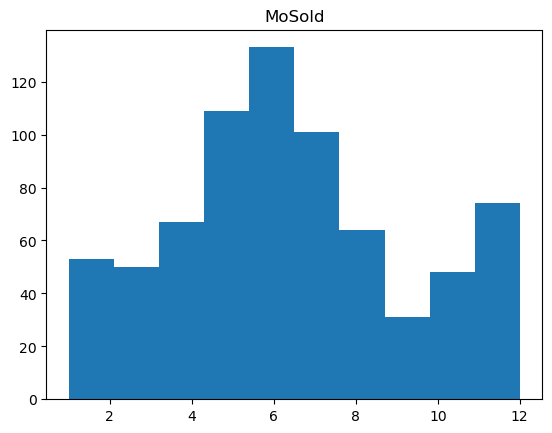

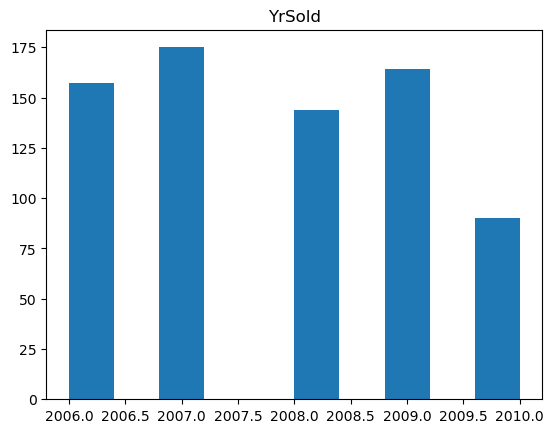

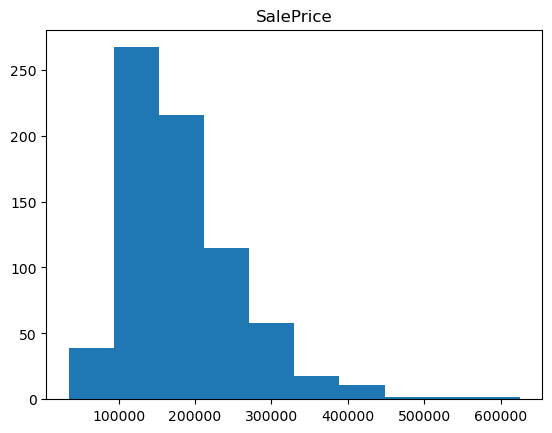

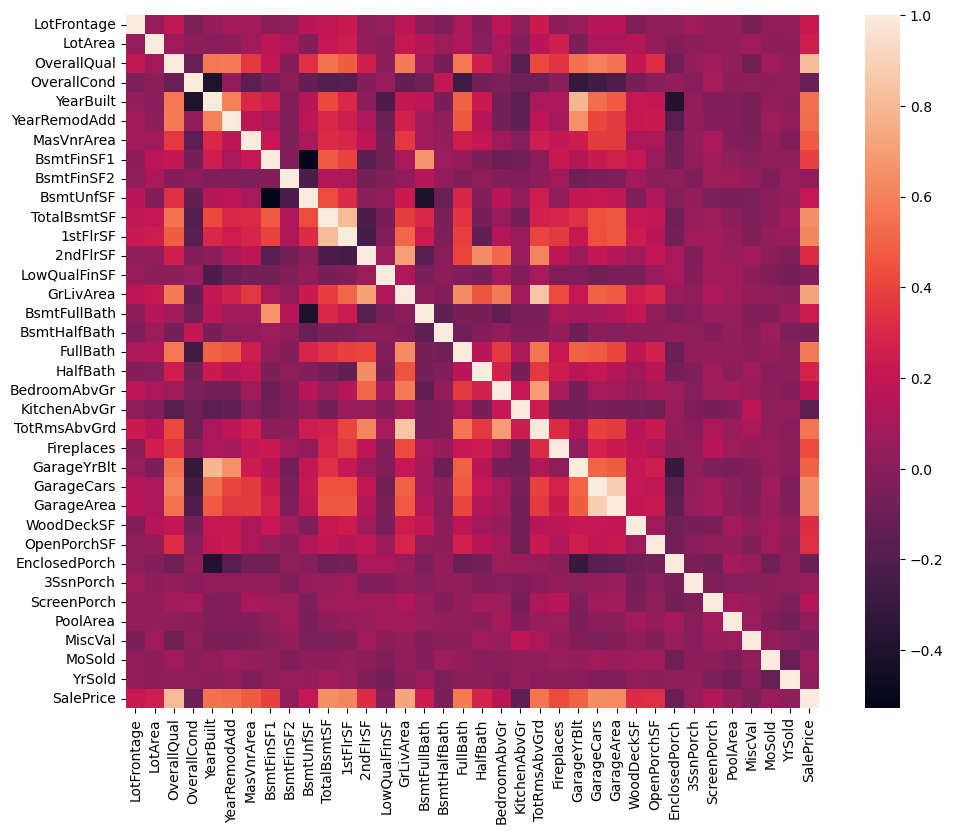

       LotFrontage        LotArea  OverallQual  OverallCond    YearBuilt  \
count   730.000000     730.000000   730.000000   730.000000   730.000000   
mean     58.991781   10849.220548     6.164384     5.538356  1972.465753   
std      34.451452   12657.729930     1.373007     1.071789    30.999041   
min       0.000000    1300.000000     1.000000     2.000000  1872.000000   
25%      47.000000    7560.000000     5.000000     5.000000  1954.250000   
50%      64.000000    9515.000000     6.000000     5.000000  1976.000000   
75%      79.000000   11569.500000     7.000000     6.000000  2002.000000   
max     313.000000  215245.000000    10.000000     9.000000  2009.000000   

       YearRemodAdd   MasVnrArea   BsmtFinSF1   BsmtFinSF2    BsmtUnfSF  ...  \
count    730.000000   730.000000   730.000000   730.000000   730.000000  ...   
mean    1985.490411   108.638356   449.226027    44.076712   575.002740  ...   
std       20.631207   187.696229   436.199596   164.898879   446.421701  ..

/Users/neal/opt/anaconda3/envs/machine-learning/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in divide
  correlation_coefficient /= X_norms


GRADIENT BOOSTING MODEL: 
Best parameters:  {'gbr__max_depth': 4, 'gbr__max_features': 9, 'gbr__min_samples_leaf': 2, 'pca__n_components': 14}
R2 with cross val 0.7277319375876612
Accuracy after running model on test set:  0.6473382738656392


In [998]:
# the kaggle dataset testing data does not have labels
# so we split the train into train and test:
all_data = pd.read_csv("train.csv")
training, testing = train_test_split(all_data, test_size=0.50, random_state=11)
training_labels = training['SalePrice']
testing_labels = testing['SalePrice']

# 1. Clean Data
training = clean_data(training)
testing = clean_data(testing)

#2. Explore Data
explore_data(training)
print(training.describe())
print(testing.describe())

# call one square chi test function:
one_square_chi(training)


# one hot encode and do an inner join to make sure we have the same shape in test and train
ohe_train = one_hot_encode(training)
ohe_test = one_hot_encode(testing)
final_train, final_test = ohe_train.align(ohe_test, join='inner', axis=1)


# 3. Normalization
train_norm, test_norm = normalize_data(final_train, final_test)


# outlier detection:
run_isolation_forest(train_norm)

# 4. Feature Engineering: 

train_norm['SalePrice'] = training_labels
test_norm['SalePrice'] = testing_labels

# perform correlation between all feats. and SalePrice
corr_salePrice(train_norm)

train_collinear = multi_collinear_removal(train_norm)
test_collinear = multi_collinear_removal(test_norm)


# 4. Run Models
do_gradient_boosting_regression(train_collinear, test_collinear)
